# Fine-tuning SAM2

## Fine-tuning 

In [1]:
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append("/home/mitochondria/Desktop/yuxuan_exp/SAM2_finetuning/segment-anything-2")

In [3]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [4]:
# - Load data and convert them in pngs and save paths in dictionary
## - process raw image tif
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image'
raw_image_tif_path = raw_image_dir / os.listdir(raw_image_dir)[0]
save_dir = data_dir / 'image_pngs'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with Image.open(raw_image_tif_path) as img:
    for i in range(img.n_frames):
        temp_filename = f'image{i:04d}.png'
        if os.path.exists(save_dir / temp_filename):
            continue
        img.seek(i)
        img.save(save_dir / temp_filename)


In [5]:
## - process label image tif
label_image_dir = data_dir / 'seg'
label_image_tif_path = label_image_dir / os.listdir(label_image_dir)[0]
save_seg_dir = data_dir / 'seg_pngs'
if not os.path.exists(save_seg_dir):
    os.makedirs(save_seg_dir)

with Image.open(label_image_tif_path) as img:
    for i in range(img.n_frames):
        temp_filename = f'seg{i:04d}.png'
        if os.path.exists(save_seg_dir / temp_filename):
            continue
        img.seek(i)
        img.save(save_seg_dir / temp_filename)

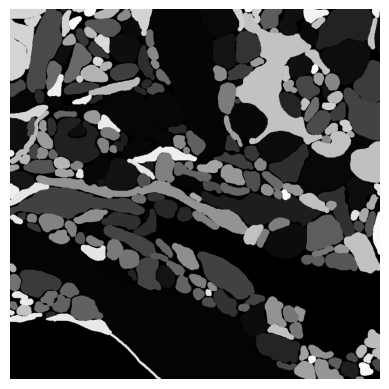

In [6]:
## - show segmentation image with 16 bits
def show_uint16_image_efficient(image_path):
    img = Image.open(image_path)

    img_array = np.array(img)

    max_id = np.max(img_array)

    plt.imshow(img_array, cmap='gray', vmin=0, vmax=max_id+1)
    plt.axis('off')
    plt.show()

show_uint16_image_efficient(save_seg_dir / 'seg0005.png')

In [7]:
## - prepare dataset path collections in dictionary 
data = []
for ff, name in enumerate(os.listdir(save_dir)):
    data.append({'image': save_dir / f'image{ff:04d}.png', 'annotation': save_seg_dir / f'seg{ff:04d}.png'})
# - split train dataset and validation dataset
valid_data = data[80:]
data = data[:80]

In [8]:
ent  = data[np.random.randint(len(data))] # choose random entry
Img = cv2.imread(str(ent["image"]), cv2.IMREAD_GRAYSCALE) # read image
ann_map = Image.open(ent['annotation'])
np.unique(ann_map)

array([  0,   1,   2,   3,   6,   7,   8,  10,  11,  12,  14,  15,  17,
        18,  19,  20,  21,  22,  23,  25,  30,  33,  34,  37,  41,  46,
        48,  51,  52,  53,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  71,  72,  73,  74,  75,  76,  79,  80,  82,  84,
        85,  86,  87,  88,  90,  91,  94,  95,  96,  97,  99, 101, 105,
       106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120,
       121, 122, 124, 126, 130, 132, 135, 139, 145, 146, 147, 149, 150,
       151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165,
       168, 169, 171, 173, 175, 176, 178, 179, 180, 184, 185, 186, 189,
       190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217,
       218, 219, 220, 221, 222, 223, 225, 227, 231, 232, 233, 235, 236,
       237, 238, 239, 240, 242, 243, 244, 246, 249, 250, 251, 252, 257,
       258, 260, 264, 265, 267, 268, 277, 280, 281, 282, 283, 28

In [9]:
def read_batch(data): # read random image and its annotaion from  the dataset (LabPics)

   #  select image

        ent  = data[np.random.randint(len(data))] # choose random entry
        Img = cv2.imread(str(ent["image"])) # read image
        ann_map = np.array(Image.open(ent['annotation']))
        ann_map = np.stack((ann_map, ) * 3, axis = -1)
        print(f'image shape: {np.array(Img).shape}')
        print(f'annotation shape: {np.array(ann_map).shape}')
   # resize image

        r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
        Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)


   # Get binary masks and points
        mat_map = ann_map
        inds = np.unique(mat_map)[1:] # load all indices
        points= []
        masks = [] 
        for ind in inds:
            mask=(mat_map == ind).astype(np.uint8) # make binary mask
            masks.append(mask)
            coords = np.argwhere(mask > 0) # get all coordinates in mask
            yx = np.array(coords[np.random.randint(len(coords))]) # choose random point/coordinate
            points.append([[yx[1], yx[0]]])
        return Img,np.array(masks),np.array(points), np.ones([len(masks),1])

img, mask_arr,  point_arr, one_arr= read_batch(data)

image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)


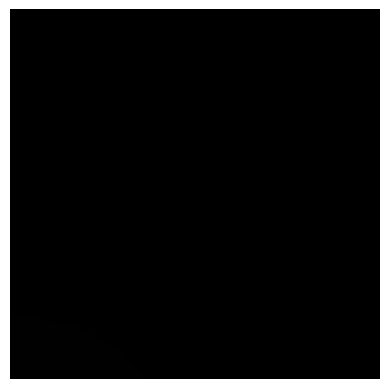

In [10]:
## - visualize some mask samples
def visualize_img(img_array):
    max_id = np.max(img_array)

    plt.imshow(img_array, cmap='gray', vmin=0, vmax=max_id+1)
    plt.axis('off')
    plt.show()
visualize_img(mask_arr[0])
    

In [11]:
len(mask_arr)

223

In [12]:
# - load checkpoints and start fine-tuning (need to load python path to get checkpoint file)

sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"


In [13]:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cpu')
predictor = SAM2ImagePredictor(sam2_model)

In [14]:
## - set training parametres:
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)
predictor.model.image_encoder.train(True)



PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [15]:
### - optimizer and scaler
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)

scaler = torch.amp.GradScaler()

In [16]:
# - force cuda operations to be synchronized
!export CUDA_LAUNCH_BLOCKING=1

In [17]:
# - fine-tuning
# - try to improve efficiency by doing min-batch stochastic gradient descent. this is just stochastic gradient descent
import torch.nn as nn

device0 = torch.device('cuda:0')
device1 = torch.device('cuda:1')
device_cpu = torch.device('cpu')

for itr in range(10000):
    with torch.amp.autocast(device_type='cpu'):
        image, mask, input_point, input_label = read_batch(data)
        if mask.shape[0] == 0: continue
        predictor.set_image(image)

        # - prompt encoding
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels), boxes=None, masks=None)


        # - mask decoder
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=[feat for feat in high_res_features],
        )


        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        # - segmentation loss calculation on CPU
        gt_mask = torch.tensor(mask.astype(np.float32))[:, :, :, 0]
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

        # - score loss calculation (intersection over union) IOU on CPU
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()

        # Move the total loss to GPU for backpropagation
        loss = (seg_loss + score_loss * 0.05)
        predictor.model.zero_grad()  # empty gradient
        scaler.scale(loss).backward()  # Backpropagate
        scaler.step(optimizer)
        scaler.update()  # Mix precision

        if itr % 1000 == 0:
            torch.save(predictor.model.state_dict(), f"./checkpoints/large_model{itr}.torch")
            print("save model")

        if itr == 0:
            mean_iou = 0
        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        print("step)", itr, "Accuracy(IOU)=", mean_iou)


image shape: (1024, 1024, 3)
annotation shape: (1024, 1024, 3)


In [ ]:
torch.save(predictor.model.state_dict(), f"./checkpoints/large_model{itr + 1}.torch")

In [ ]:
# ### - main training loop; does SAM requires RGB???
# import torch.nn as nn

# device0 = torch.device('cuda:0')
# device1 = torch.device('cuda:1')

# for itr in range(100000):
#     with torch.amp.autocast(device_type='cuda'):
#         image, mask, input_point, input_label = read_batch(data)
#         if mask.shape[0] == 0: continue
#         predictor.set_image(image)

#         print('*******************Start to do prompt encoding*******************')
#         # - prompt encoding
#         mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits = None, normalize_coords = True)
#         sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points = (unnorm_coords, labels), boxes = None, masks=None)

#         print('*******************Start to do mask decoder*******************')
#         # - mask decoder
#         batched_mode = unnorm_coords.shape[0] > 1
#         high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
#         low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
#         prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

#         print('*******************Start to calculate loss*******************')
#         # - segmentation loss calculation
#         gt_mask = torch.tensor(mask.astype(np.float32))[:, :, :, 0].to(device1)
#         prd_mask = torch.sigmoid(prd_masks[:, 0]).to(device1)
#         print(f'gt_mask shape: {gt_mask.shape}')
#         print(f'prd_mask shape: {prd_mask.shape}')
#         print(f'prd_mask shape: {prd_masks.shape}')
#         seg_loss =  (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss

#         print('start to add iou into loss')
#         # - score loss calculation (intersecition over union) IOU

#         inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
#         iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
#         prd_scores = prd_scores.to(device1)
#         iou = iou.to(device1)
#         score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
#         loss=seg_loss+score_loss*0.05  # mix losses
        
#         print('*******************Start to do gradient descent*******************')
#         predictor.model.zero_grad() # empty gradient
#         scaler.scale(loss).backward()  # Backpropogate
#         scaler.step(optimizer)
#         scaler.update() # Mix precision


#         if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch");print("save model")

#         # Display results

#         if itr==0: mean_iou=0
#         mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
#         print("step)",itr, "Accuracy(IOU)=",mean_iou)